# Homework 3

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

### Name: Eshan Kumar

### UNI: ek3227

## 0 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Part 1: Imbalanced Dataset
This part of homework helps you practice to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

## Data processing and exploration
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examine the class label imbalance
Let's look at the dataset imbalance:

**Q1. How many observations are there in this dataset? How many of them have positive label (labeled as 1)?**

In [3]:
print(f"The dataset has {len(raw_df)} observations, and {raw_df.shape[1]} features")
print(f"The dataset has {(raw_df['Class'] == 1).sum()} observations with a positive label")

The dataset has 284807 observations, and 31 features
The dataset has 492 observations with a positive label


### 1.2 Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [4]:
cleaned_df = raw_df.copy()

# We don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**Q2. Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42.**

In [5]:
X_data = cleaned_df.drop(columns=['Class'])
y_data = cleaned_df['Class']

X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_data, y_data, stratify=y_data, 
                                                        test_size = 0.2, random_state=42)

In [7]:
print("Development data:")
print(y_dev.value_counts(normalize=True))

print("\nTest data:")
print(y_test.value_counts(normalize=True))

Development data:
0    0.998271
1    0.001729
Name: Class, dtype: float64

Test data:
0    0.99828
1    0.00172
Name: Class, dtype: float64


**Q3. Normalize the input features using the sklearn StandardScaler. Print the shape of your development features and test features.**

In [6]:
# Your Code Here
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev_raw) #fit and transform based on dev, but only transform for test
X_test = scaler.transform(X_test_raw)

print(f"Shape of development features:\t{X_dev.shape}")
print(f"Shape of test features:\t\t{X_test.shape}")

Shape of development features:	(227845, 29)
Shape of test features:		(56962, 29)


### 1.3 Define the model and metrics
**Q4. First, fit a default logistic regression model. Print the AUC and average precision of 5-fold cross validation.**

In [8]:
# Your Code Here
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

scores = cross_validate(LogisticRegression(), X_dev, y_dev, cv=5, scoring=['roc_auc', 'average_precision'])
print("Default logistic regression")
print(f"The AUC is:\t\t\t{scores['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores['test_average_precision'].mean()}")

Default logistic regression
The AUC is:			0.9763686302709351
The Average Precision is:	0.7620017185050845


## Random undersampling

**Q5.1. Perform random under sampling on the development set. What is the shape of your development features? How many  positive and negative labels are there in your development set? (Please set random state as 42 when performing random under sampling)**

In [9]:
#We perform undersampling, where the majority class is sampled less, same amount of data as minority (large data loss)
rus = RandomUnderSampler(replacement=False, random_state=42)
X_dev_undersample, y_dev_undersample = rus.fit_resample(X_dev, y_dev)
print(f"Shape before undersampling:\t\t {X_dev.shape}")
print(f"Shape after undersampling:\t\t {X_dev_undersample.shape}")

print("\nClass labels after undersampling:")
print(y_dev_undersample.value_counts())

Shape before undersampling:		 (227845, 29)
Shape after undersampling:		 (788, 29)

Class labels after undersampling:
0    394
1    394
Name: Class, dtype: int64


**Q5.2. Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random under sampling)**

In [10]:
# In pipeline
"""
rus = RandomUnderSampler(replacement=False, random_state=42)
rus_pipe = imb_make_pipeline(rus, LogisticRegression())
scores_rus = cross_validate(rus_pipe, X_dev, y_dev, cv=5, scoring=['roc_auc', 'average_precision'])
print("Undersampling in Pipeline\n-----------------------------")
print("Logistic regression after undersampling")
print(f"The AUC is:\t\t\t{scores_rus['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores_rus['test_average_precision'].mean()}")
print("\nUndersampling Not in Pipeline\n-----------------------------")"""

# Metrics after Undersampling
scores_rus = cross_validate(LogisticRegression(), X_dev_undersample, y_dev_undersample, cv=5, scoring=['roc_auc', 'average_precision'])
print("Logistic regression after undersampling")
print(f"The AUC is:\t\t\t{scores_rus['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores_rus['test_average_precision'].mean()}")


Logistic regression after undersampling
The AUC is:			0.9802694341390064
The Average Precision is:	0.9852702116626835


## Random Oversampling

**Q6.1. Perform random over sampling on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing random over sampling)**

In [11]:
# We perform oversampling, where the minority class is repeatedly sampled with replacement (danger of overfitting)
ros = RandomOverSampler(random_state=42)
X_dev_oversample, y_dev_oversample = ros.fit_resample(X_dev, y_dev)
print(f"Shape before oversampling:\t\t {X_dev.shape}")
print(f"Shape after oversampling:\t\t {X_dev_oversample.shape}")

print("\nClass labels after oversampling:")
print(y_dev_oversample.value_counts())

Shape before oversampling:		 (227845, 29)
Shape after oversampling:		 (454902, 29)

Class labels after oversampling:
0    227451
1    227451
Name: Class, dtype: int64


**Q6.2. Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random over sampling)**

In [12]:
"""
ros = RandomOverSampler(random_state=42)
ros_pipe = imb_make_pipeline(ros, LogisticRegression())
scores_ros = cross_validate(ros_pipe, X_dev, y_dev, cv=5, scoring=['roc_auc', 'average_precision'])
"""
# Metrics after oversampling
scores_ros = cross_validate(LogisticRegression(), X_dev_oversample, y_dev_oversample, cv=5, scoring=['roc_auc', 'average_precision'])

print("Logistic Regression after Oversampling")
print(f"The AUC is:\t\t\t{scores_ros['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores_ros['test_average_precision'].mean()}")

Logistic Regression after Oversampling
The AUC is:			0.9889049735845417
The Average Precision is:	0.990722505917906


## Synthetic Minority Oversampling Technique (SMOTE)

**Q7.1. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing SMOTE)**

In [18]:
# We do SMOTE, which generates synthetic data for the minority class (based on neighbors), then oversamples 
smote = SMOTE(random_state=42)
X_dev_smote, y_dev_smote = smote.fit_resample(X_dev, y_dev)
print(f"Shape before SMOTE:\t\t {X_dev.shape}")
print(f"Shape after SMOTE:\t\t {X_dev_smote.shape}")

print("\nClass labels after synthetic oversampling:")
print(y_dev_smote.value_counts())

Shape before SMOTE:		 (227845, 29)
Shape after SMOTE:		 (454902, 29)

Class labels after synthetic oversampling:
0    227451
1    227451
Name: Class, dtype: int64


**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing SMOTE)**

In [14]:
"""smote = SMOTE(random_state=42)
smote_pipe = imb_make_pipeline(smote, LogisticRegression())
scores_smote = cross_validate(smote_pipe, X_dev, y_dev, cv=5, scoring=['roc_auc', 'average_precision'])"""

# Metrics after SMOTE
scores_smote = cross_validate(LogisticRegression(), X_dev_smote, y_dev_smote, cv=5, scoring=['roc_auc', 'average_precision'])

print("Logistic Regression after Synthetic Minority Oversampling Technique (SMOTE)")
print(f"The AUC is:\t\t\t{scores_smote['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores_smote['test_average_precision'].mean()}")

Logistic Regression after Synthetic Minority Oversampling Technique (SMOTE)
The AUC is:			0.9908623848900749
The Average Precision is:	0.9918943699287024


**Q8. Plot confusion matrices on the test set for all four models above. Comment on your result.**

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
# Refit all logistic regression models with diff data
lr_def = LogisticRegression().fit(X_dev, y_dev)
lr_rus = LogisticRegression().fit(X_dev_undersample, y_dev_undersample)
lr_ros = LogisticRegression().fit(X_dev_oversample, y_dev_oversample)
lr_smote = LogisticRegression().fit(X_dev_smote, y_dev_smote)

# Get predictions from each model
y_def_pred = lr_def.predict(X_test)
y_rus_pred = lr_rus.predict(X_test)
y_ros_pred = lr_ros.predict(X_test)
y_smote_pred = lr_smote.predict(X_test)

# Create confusion matrices based on predictions and true data
cm_def = confusion_matrix(y_test, y_def_pred)
cm_rus = confusion_matrix(y_test, y_rus_pred)
cm_ros = confusion_matrix(y_test, y_ros_pred)
cm_smote = confusion_matrix(y_test, y_smote_pred)

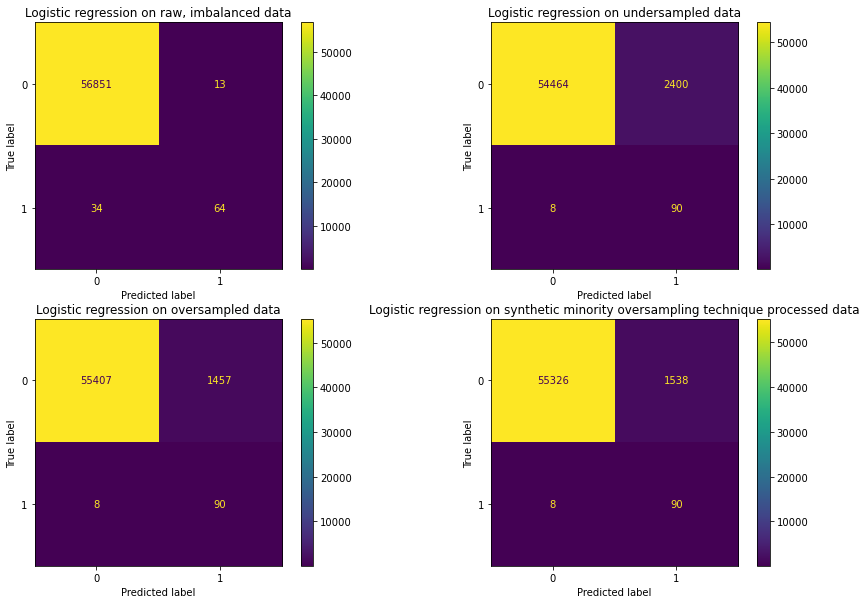

In [19]:
# Plotting all confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp_def = ConfusionMatrixDisplay(cm_def)
ax[0].title.set_text("Logistic regression on raw, imbalanced data")
disp_def.plot(ax = ax[0])

disp_rus = ConfusionMatrixDisplay(cm_rus)
ax[1].title.set_text("Logistic regression on undersampled data")
disp_rus.plot(ax = ax[1])

disp_ros = ConfusionMatrixDisplay(cm_ros)
ax[2].title.set_text("Logistic regression on oversampled data")
disp_ros.plot(ax = ax[2])

disp_smote = ConfusionMatrixDisplay(cm_smote)
ax[3].title.set_text("Logistic regression on synthetic minority oversampling technique processed data")
disp_smote.plot(ax = ax[3])

**Q9. Plot the ROC for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

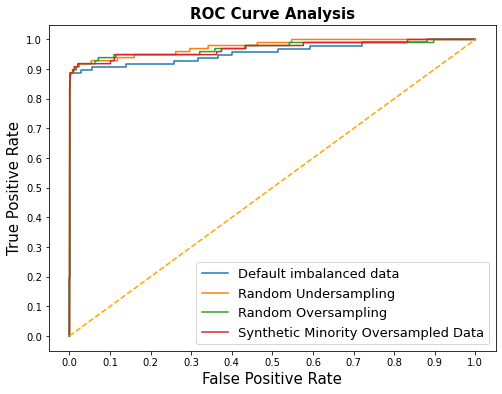

In [21]:
#Plotting the Reciever Operating curve (false positive rate vs true positive rate) for each model

# Getting the probabilities with each prediction, necessary for ROC
y_def_pred_prob = lr_def.predict_proba(X_test)[:,1]
y_rus_pred_prob = lr_rus.predict_proba(X_test)[:,1]
y_ros_pred_prob = lr_ros.predict_proba(X_test)[:,1]
y_smote_pred_prob = lr_smote.predict_proba(X_test)[:,1]

fig = plt.figure(figsize=(8,6))

fpr_def, tpr_def, thresholds_def = roc_curve(y_test, y_def_pred_prob, pos_label = 1)
plt.plot(fpr_def, tpr_def, label='Default imbalanced data')

fpr_rus, tpr_rus, thresholds_rus = roc_curve(y_test, y_rus_pred_prob, pos_label = 1)
plt.plot(fpr_rus, tpr_rus, label = 'Random Undersampling')

fpr_ros, tpr_ros, thresholds_ros = roc_curve(y_test, y_ros_pred_prob, pos_label = 1)
plt.plot(fpr_ros, tpr_ros, label = 'Random Oversampling')

fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_smote_pred_prob, pos_label = 1)
plt.plot(fpr_smote, tpr_smote, label = 'Synthetic Minority Oversampled Data')

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

**Q10. Plot the precision-recall curve for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

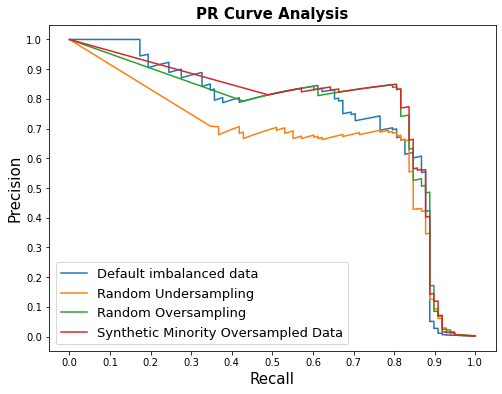

In [23]:
# Plot the Precision-Recall curve for all models
fig = plt.figure(figsize=(8,6))

precision_def, recall_def, thresholds_def = precision_recall_curve(y_test, y_def_pred_prob, pos_label = 1)
plt.plot(recall_def, precision_def, label='Default imbalanced data')

precision_rus, recall_rus, thresholds_rus = precision_recall_curve(y_test, y_rus_pred_prob, pos_label = 1)
plt.plot(recall_rus, precision_rus, label = 'Random Undersampling')

precision_ros, recall_ros, thresholds_ros = precision_recall_curve(y_test, y_ros_pred_prob, pos_label = 1)
plt.plot(recall_ros, precision_ros, label = 'Random Oversampling')

precision_smote, recall_smote, thresholds_smote = precision_recall_curve(y_test, y_smote_pred_prob, pos_label = 1)
plt.plot(recall_smote, precision_smote, label = 'Synthetic Minority Oversampled Data')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('PR Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')

plt.show()

**Q11. Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

In [24]:
# Creating Logistic regression model with balanced class weights (data weighted less if in majority class)
lr_balanced = LogisticRegression(class_weight = 'balanced')
scores_smote = cross_validate(lr_balanced, X_dev, y_dev, cv=5, scoring=['roc_auc', 'average_precision'])

print("Balanced Logistic Regression (after adding class weights)")
print(f"The AUC is:\t\t\t{scores_smote['test_roc_auc'].mean()}")
print(f"The Average Precision is:\t{scores_smote['test_average_precision'].mean()}")

Balanced Logistic Regression (after adding class weights)
The AUC is:			0.9806071364184955
The Average Precision is:	0.7521264537120119


Confusion Matrix for Blanaced Logistic Regression


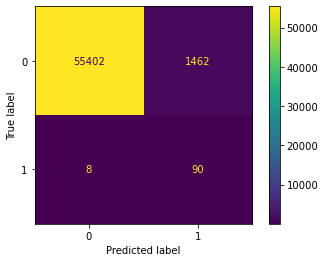

In [23]:
lr_balanced = LogisticRegression(class_weight = 'balanced')
lr_balanced.fit(X_dev, y_dev)

y_balanced_pred = lr_balanced.predict(X_test)
y_balanced_pred_prob = lr_balanced.predict_proba(X_test)[:,1]

print("Confusion Matrix for Blanaced Logistic Regression")
cm_balanced = confusion_matrix(y_test, y_balanced_pred)
disp = ConfusionMatrixDisplay(cm_balanced)
disp.plot()

**Q12. Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots. Make sure to label the axes and legend. Comment on your result.**

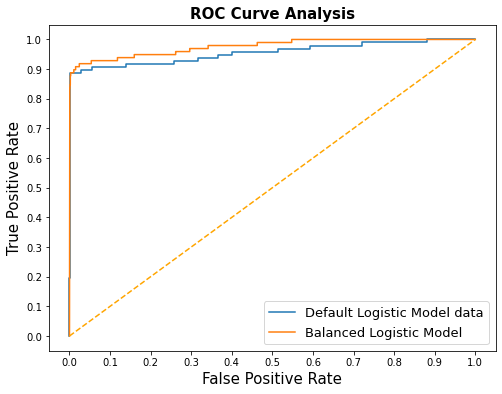

In [24]:
fig = plt.figure(figsize=(8,6))

plt.plot(fpr_def, tpr_def, label='Default Logistic Model data')

fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, y_balanced_pred_prob, pos_label = 1)
plt.plot(fpr_rus, tpr_rus, label = 'Balanced Logistic Model')

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

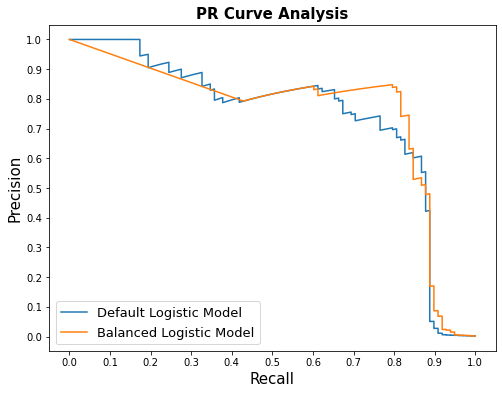

In [25]:
fig = plt.figure(figsize=(8,6))

plt.plot(recall_def, precision_def, label='Default Logistic Model')

precision_bal, recall_bal, thresholds_bal = precision_recall_curve(y_test, y_balanced_pred_prob, pos_label = 1)
plt.plot(recall_bal, precision_bal, label = 'Balanced Logistic Model')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('PR Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower left')

plt.show()

# Part 2: Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source is on Coursework.

In [27]:
cell_gene_counts_df = pd.read_csv('mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [28]:
cell_metadata_df = pd.read_csv('mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [29]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [30]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## PCA

**Q1. Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [31]:
from sklearn.decomposition import PCA

In [32]:
# PCA, projecting data onto first 50 principal components
pca50 = PCA(n_components=50)
X_pca50 = pca50.fit_transform(cell_gene_counts_df)
print(f"Shape of data before PCA:\t{cell_gene_counts_df.shape}")
print(f"Shape of data after PCA:\t{X_pca50.shape}")

Shape of data before PCA:	(1000, 18585)
Shape of data after PCA:	(1000, 50)


**Q2. Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

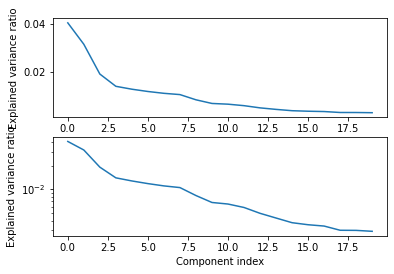

In [33]:
# Amount of explained variance in first 20 components
fig, axes = plt.subplots(2)
axes[0].plot(pca50.explained_variance_ratio_[:20])
axes[1].semilogy(pca50.explained_variance_ratio_[:20])

for ax in axes:
    ax.set_xlabel("Component index")
    ax.set_ylabel("Explained variance ratio")


**Q3. For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [34]:
loadings = pca50.components_
num_pc = pca50.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = cell_gene_counts_df.columns.values
loadings_df = loadings_df.set_index('variable')
display(loadings_df.head(5))
loadings_df.shape

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
variable,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000837,-0.001160,0.004848,-0.000903,-0.007460,0.001687,0.000577,-0.004607,-0.006558,0.003205,...,-0.000584,0.001442,-0.001561,0.002952,-0.005005,-0.008407,-0.002066,5.964357e-07,-0.000434,-0.002037
0610007C21Rik,0.006774,-0.006888,-0.006253,0.000179,-0.014241,0.004574,0.007347,-0.002526,-0.012677,0.007286,...,-0.000821,-0.005752,-0.010535,-0.002616,-0.003285,-0.000153,-0.004283,-7.922194e-04,0.005691,-0.000081
0610007L01Rik,0.003400,0.005564,-0.009035,0.007410,-0.004466,0.002710,0.001636,0.001063,-0.002544,-0.000452,...,-0.001607,-0.003412,-0.003196,0.001921,0.001156,0.000434,-0.002241,2.287635e-03,0.009950,0.004140
0610007N19Rik,-0.002282,0.007633,-0.000754,0.001698,-0.016108,0.013897,-0.041249,-0.007977,-0.000246,-0.002618,...,-0.001135,0.002512,-0.002736,-0.003576,0.004747,0.009024,0.009158,2.524318e-03,0.001586,-0.002970
0610007P08Rik,0.005332,-0.002157,-0.005430,0.000568,-0.000213,-0.000175,0.002253,-0.001389,-0.004391,0.003169,...,0.000712,0.000039,0.008219,0.004259,0.004371,0.002567,0.003500,3.050824e-03,0.003572,0.008250


(18585, 50)

In [35]:
# Finding the top 10 weights and corresponding genes - which 10 genes are weighted most, in PC1
display(loadings_df['PC1'].sort_values(ascending=False)[:10].to_frame())

,PC1
variable,
Nsg2,0.026673
St8sia3,0.026595
Ptpn5,0.026588
Kcnj4,0.026539
Rasgef1a,0.026347
Camkv,0.026221
Hpca,0.026173
Cpne5,0.026022
Nrsn2,0.025979


**Q4. Plot the projection of the data onto the first two principal components using a scatter plot.**

Text(0, 0.5, 'Second Principal component')

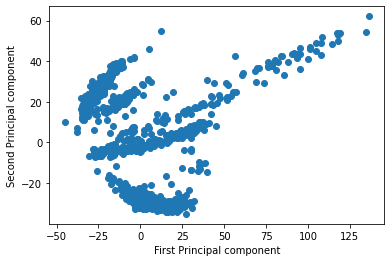

In [36]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cell_gene_counts_df)
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("First Principal component")
plt.ylabel("Second Principal component")

**Q5. Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.


cell_ontology_class Categories:
['astrocyte' 'oligodendrocyte' 'endothelial cell' 'neuron'
 'oligodendrocyte precursor cell' 'Bergmann glial cell' 'brain pericyte']

subtissue Categories:
['Striatum' 'Cortex' 'Hippocampus' 'Cerebellum']

mouse.sex Categories:
['F' 'M']

mouse.id Categories:
['3_38_F' '3_56_F' '3_10_M' '3_9_M' '3_8_M' '3_11_M' '3_39_F']


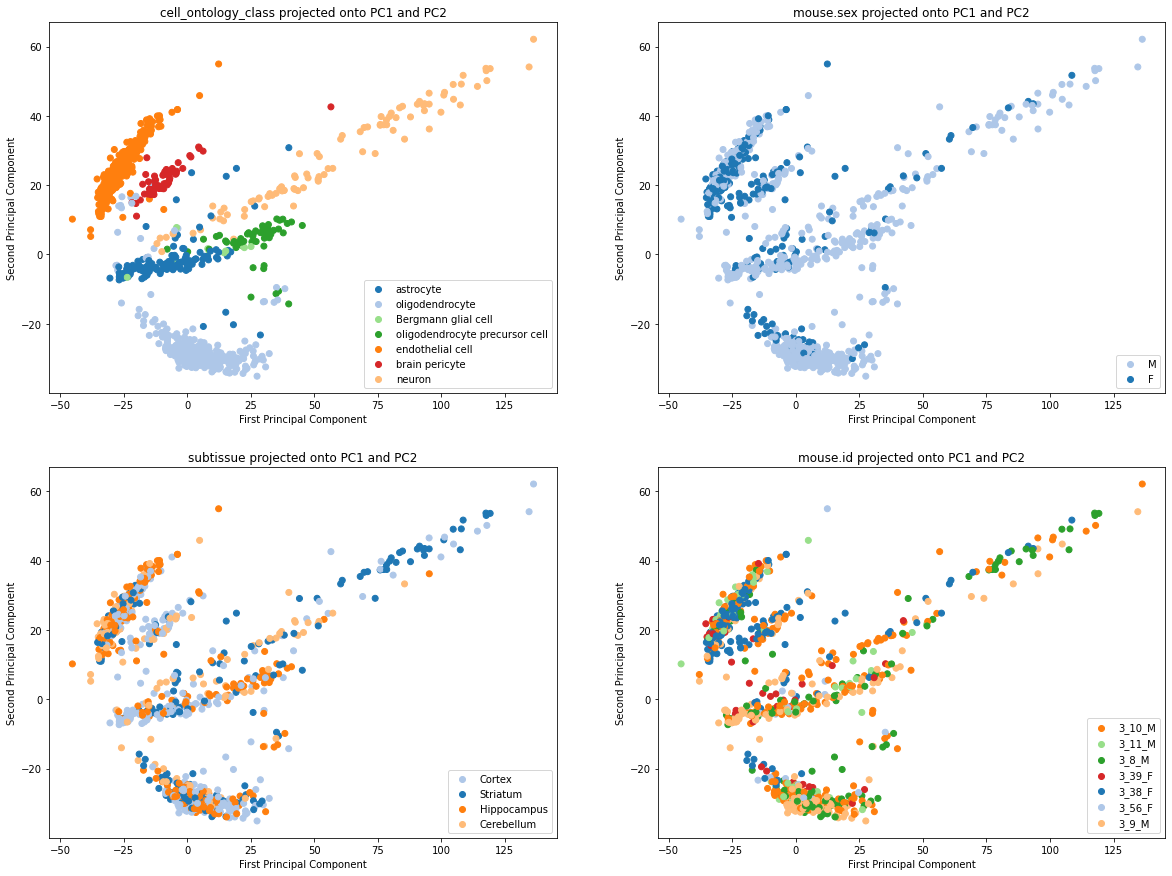

In [43]:
metadata_annotations = ['cell_ontology_class', 'subtissue', 'mouse.sex','mouse.id']

# Getting 20 colors from seaborn palette
color = plt.cm.tab20.colors
sns.set_palette(color, len(color))
rgb_values = sns.color_palette()

figure, axs = plt.subplots(int(len(metadata_annotations)/2), 2, figsize = (20, 15))

# For each annotation of interest with categorical variables, create plot
for index, annotation in enumerate(metadata_annotations):
    xval = index%2
    yval = int(index/2)
    
    color_labels = cell_metadata_df[annotation].unique()
    print(f"\n{annotation} Categories:\n{color_labels}")
    color_map = dict(zip(color_labels, rgb_values))
    
    # Plot scatterplot, coloring according to category's mapping to color
    axs[xval, yval].scatter(X_pca[:, 0], X_pca[:, 1], c=cell_metadata_df[annotation].map(color_map))
    # Plot empty scatterplots (for labels and legend)
    for l in set(color_labels):
        axs[xval, yval].scatter([],[], color=color_map[l], label=l)
    axs[xval, yval].legend(prop={'size':10}, loc='lower right')
    axs[xval, yval].set(title = annotation+" projected onto PC1 and PC2", xlabel='First Principal Component', ylabel='Second Principal Component')

**Q6. Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

Based on the plots above, the first two principal components correspond to the Ontology classes of the cells. The first two principal components are extracting meaningful hidden, lower dimensional structure in the data based on the cell's genes. 

This is good, because it means that given a new set of genes, we can easily tell what type of cell it is, and it also means that there is no significant difference in cells across Mice sex or ID. 

## K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Q7. Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [239]:
import random
import math
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    centers = []
    m = len(X)
    n = len(X[0])
    
    # Initializing centers as random points in data
    centIdx = random.sample(range(1, m), k)
    for i in range(k):
        rand = np.random
        centers.append(X[centIdx[i]])
    initial = np.stack(centers, axis=0)
    
    # Over each iteration, change cluster assignment of each point
    clusterAssignment = np.zeros(m)
    for i in range(iters):
        clusters = {}
        
        # For each point, find the center that is the shortest euclidean distance away
        for p_idx, point in enumerate(X):
            shortestDist = 1e9
            closest = 0
            for c_idx, center in enumerate(centers):
                cDistance = math.dist(point, center)
                if cDistance < shortestDist:
                    shortestDist = cDistance
                    closest = c_idx
            
            # Change the cluster assignment for this point, and add to cluster dictionary
            clusterAssignment[p_idx] = closest
            if closest in clusters:
                clusters[closest].append(point)
            else:
                clusters[closest] = [point]

        # For each cluster, find the mean, and assign the center to this value
        for key in clusters:
            clusterArr = np.stack(clusters[key], axis=0 ) # Stack all points (list of np arrays -> 2D np array)
            centers[key] = clusterArr.mean(axis=0)
            
        
    # Final centers
    final = np.stack(centers, axis=0)
    
    #Extra code to plot initial random centers, and final center locations
    """
    plt.figure(figsize=(10, 6))
    plt.title('K-Means clustering', fontweight='bold', fontsize=15)
    plt.scatter(X[:, 0], X[:, 1], s=10, label='Data')
    plt.scatter(initial[:,0], initial[:,1], c='r', label='Initial Centers (random)')
    plt.scatter(final[:,0], final[:,1], c='orange', label='Final Centers')
    plt.legend(prop={'size':13}, loc='upper left')
    plt.xlabel('$x_1$', fontsize=15)
    plt.ylabel('$x_2$', fontsize=15)
    """
    
    return clusterAssignment
    
    

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

Text(0, 0.5, '$x_2$')

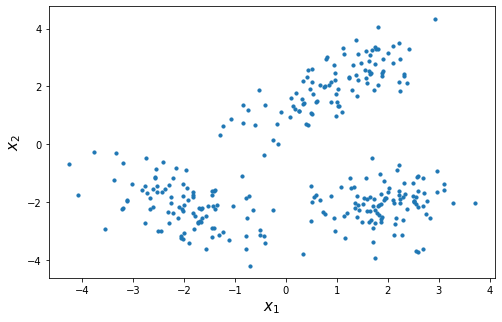

In [232]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.scatter
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

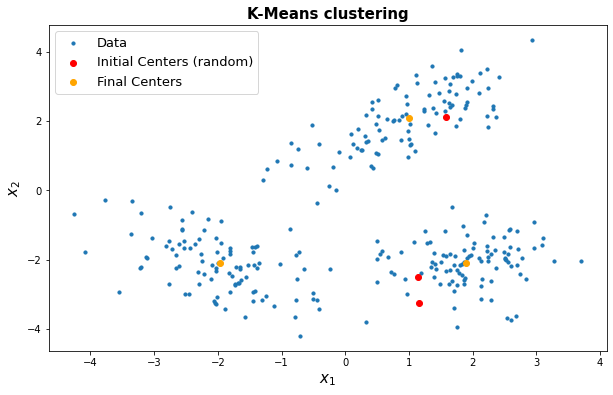

In [233]:
k = 3
assignment = kmeans(X, k)

**Q8. Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

In [234]:
data_X = pd.DataFrame(X)
data_X['assignment'] = assignment
data_X.head(5)

,0,1,assignment
0,-0.602453,0.650629,2.0
1,-0.527504,1.889762,2.0
2,-0.253469,0.128446,2.0
3,0.252962,1.157236,2.0
4,0.956516,2.216202,2.0


Text(0, 0.5, '$x_2$')

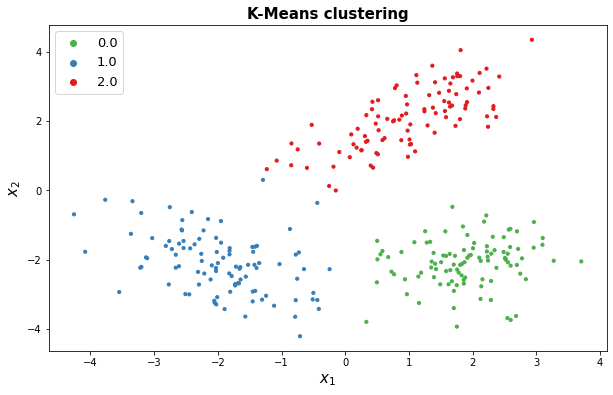

In [334]:
color_labels = data_X['assignment'].unique()
rgb_values = sns.color_palette("Set1", len(color_labels))
color_map = dict(zip(color_labels, rgb_values))


plt.figure(figsize=(10, 6))
plt.title('K-Means clustering', fontweight='bold', fontsize=15)
plt.scatter(X[:, 0], X[:, 1], s=10, c=data_X['assignment'].map(color_map))
for l in set(color_labels):
    plt.scatter([],[], color=color_map[l], label=l)
plt.legend(prop={'size':13}, loc='upper left')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Q9. Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [242]:
k = 20
assignment = kmeans(cell_gene_counts_df.to_numpy(), k)
cell_gene_counts_df['assignment'] = assignment
cell_gene_counts_df.head(5)

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,assignment
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021,...,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567,1.0
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021,...,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681,1.0
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253,...,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260,6.0
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021,...,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681,9.0
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021,...,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681,1.0


Text(0, 0.5, '$x_2$')

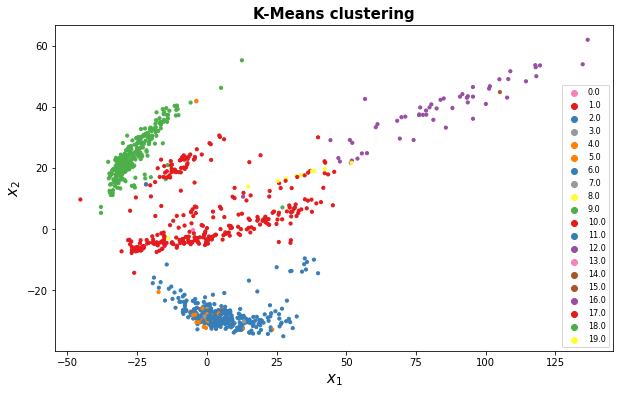

In [335]:
# Plotting the 20 clusters (using the first two principal components to visualize)
color_labels = cell_gene_counts_df['assignment'].unique()
rgb_values = sns.color_palette("Set1", len(color_labels))
color_map = dict(zip(color_labels, rgb_values))

plt.figure(figsize=(10, 6))
plt.title('K-Means clustering', fontweight='bold', fontsize=15)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=cell_gene_counts_df['assignment'].map(color_map))
for l in set(color_labels):
    plt.scatter([],[], color=color_map[l], label=l)
plt.legend(prop={'size':8}, loc='best')
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

## t-SNE (t-distributed Stochastic Neighbor Embedding)

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Q10. Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [249]:
from sklearn.manifold import TSNE

In [251]:
# We first project the data onto the first 20 principal components so that t-SNE does not have to 
# deal with too many features
pca20 = PCA(n_components=20)
X_pca20 = pca20.fit_transform(cell_gene_counts_df)
print(f"Shape of data before PCA:\t{cell_gene_counts_df.shape}")
print(f"Shape of data after PCA:\t{X_pca20.shape}")
cell_gene_counts_pca20_df = pd.DataFrame(X_pca20)
cell_gene_counts_pca20_df.head(5)

Shape of data before PCA:	(1000, 18586)
Shape of data after PCA:	(1000, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15.256962,21.931566,30.469384,17.952384,-63.176606,57.614039,31.230366,193.808867,4.484859,-12.620111,-6.458419,-10.121800,-3.670259,7.086269,28.849787,-82.045426,-37.713763,-13.652845,7.909711,-122.048171
1,-19.233608,-3.431613,37.223547,-7.733474,0.752564,-5.829446,1.531071,-0.026865,-1.998196,4.139572,3.680631,-1.275159,-5.827825,2.174777,6.305302,1.449225,3.894834,-0.019698,0.056649,-0.299789
2,1.578050,-25.984169,-9.114340,1.442781,3.847882,-0.632663,-2.124620,2.431029,3.465876,3.904825,-0.259680,-0.741593,-4.606469,0.302021,2.710766,0.129334,3.214796,-0.940695,0.071314,0.749553
3,-15.267244,38.312164,-36.928226,5.858370,-11.135440,3.784902,15.135003,-4.743621,-7.033908,6.228218,-1.479939,3.771508,-2.120827,6.843001,4.286536,-0.021016,-1.290947,-1.465744,4.029269,2.119246
4,-15.369264,-3.453291,38.770220,-6.349720,-4.916057,-5.345017,5.300592,-2.074967,-6.482756,3.793869,6.558924,4.180229,2.127367,-1.040450,-0.820960,0.271321,-1.359413,-0.563509,-0.081163,-1.456375


In [362]:
# Next, we use t-SNE to reduce this dataset to two dimensions
# Perplexity = 30 seemed to be a good default but this can be modified
X_tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random').fit_transform(X_pca20)
print(f"Shape of data before t-SNE:\t{X_pca20.shape}")
print(f"Shape of data after t-SNE:\t{X_tsne.shape}")
cell_gene_counts_tsne_df = pd.DataFrame(X_tsne)
cell_gene_counts_tsne_df.head(5)

Shape of data before t-SNE:	(1000, 20)
Shape of data after t-SNE:	(1000, 2)


,0,1
0,4.582921,-2.364437
1,-2.398402,-0.518913
2,28.087152,-3.717163
3,-49.172596,12.544869
4,-2.909713,2.517500


**Q11. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

[Text(0.5, 1.0, 'Data projected onto first two t-SNE dimensions'),
 Text(0.5, 0, 'First t-SNE dimension'),
 Text(0, 0.5, 'Second t-SNE dimension')]

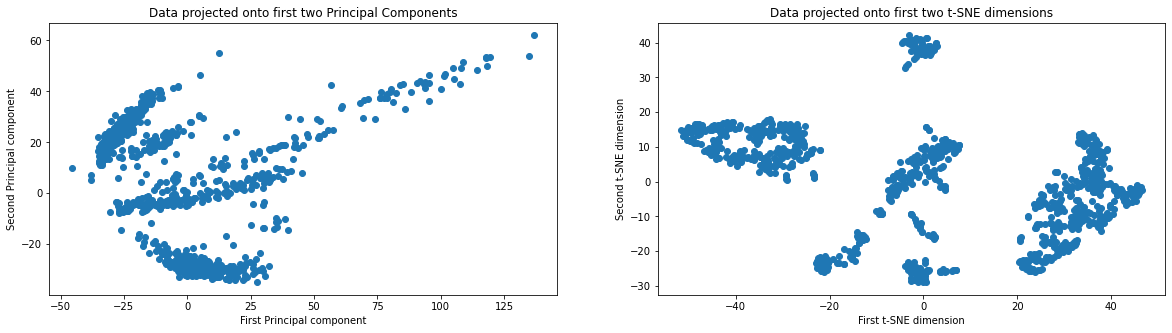

In [363]:
# Plotting the data projected onto the first two principal components and onto the first two t-SNE dimensions
figure, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1])
axs[0].set(title = 'Data projected onto first two Principal Components', 
           xlabel = "First Principal component", ylabel = "Second Principal component")

axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1])
axs[1].set(title = 'Data projected onto first two t-SNE dimensions', 
           xlabel = "First t-SNE dimension", ylabel = "Second t-SNE dimension")


**Q12. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

In [364]:
# Create a dataframe for the t-SNE data and add a column for assignment to help with plotting
tsne_df = pd.DataFrame(X_tsne)
tsne_df['assignment'] = assignment
tsne_df.head(5)

,0,1,assignment
0,4.582921,-2.364437,1.0
1,-2.398402,-0.518913,1.0
2,28.087152,-3.717163,6.0
3,-49.172596,12.544869,9.0
4,-2.909713,2.517500,1.0


[Text(0.5, 1.0, 'Data projected onto first two t-SNE dimensions, colored by cluster'),
 Text(0.5, 0, 'First t-SNE dimension'),
 Text(0, 0.5, 'Second t-SNE dimension')]

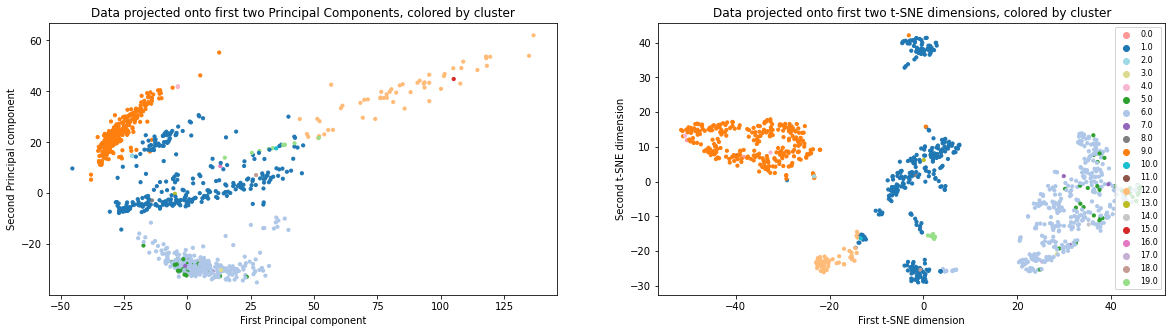

In [365]:
figure, axs = plt.subplots(1, 2, figsize = (20, 5))

# Another way to get a random shuffling of colors for plotting
#color = tuple(random.sample(plt.cm.tab20.colors, len(plt.cm.tab20.colors))) 
color = plt.cm.tab20.colors
sns.set_palette(color, len(color_labels))
rgb_values = sns.color_palette()

#Plotting the data projected onto the first two PC's, colored by cluster (K-means clustering)
color_labels = cell_gene_counts_df['assignment'].unique()
color_map = dict(zip(color_labels, rgb_values))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=cell_gene_counts_df['assignment'].map(color_map))
axs[0].set(title = 'Data projected onto first two Principal Components, colored by cluster', 
           xlabel = "First Principal component", ylabel = "Second Principal component")

#Plotting the data projected onto the first two t-SNE dimensions, colored by the same K-means clustering found before
color_labels = tsne_df['assignment'].unique()
color_map = dict(zip(color_labels, rgb_values))

axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, c=tsne_df['assignment'].map(color_map))
for l in set(color_labels):
    axs[1].scatter([],[], color=color_map[l], label=l)
axs[1].legend(prop={'size':8}, loc='best')
axs[1].set(title = 'Data projected onto first two t-SNE dimensions, colored by cluster', 
           xlabel = "First t-SNE dimension", ylabel = "Second t-SNE dimension")

**Q13. Why is there overlap between points in different clusters in the t-SNE plot above?**

t-SNE does not preserve distances nor density, so the clusters seen in the data projected onto the t-SNE dimensions may not correspond to the clusters found in the higher dimensional data after K-means - the clusters found in t-SNE may simply be artifacts of the t-SNE process, and these cluster shapes can change significantly as the perplexity is changed. Additionally, the original data points are assumed to follow a local Gaussian distribution before t-SNE, which is not the case with this data.

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.